In [1]:
# Summer 2021 Internship project with Oak Ride National Laboratory (ORNL)
# Code Written By: Arjun Viswanathan
# Mentored By: Dr. Junqi Yin
# Date Started: 6/7/2021
# Date TBC: 8/13/2021
# All datasets provided by Dr. Yin

import h5py
import numpy as np
from matplotlib import pyplot as plt
import time
from tensorflow import keras
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, UpSampling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input, Model

In [2]:
print(str(time.ctime()) + ": Initializing...")
sarsmerscov_train = h5py.File('/ccs/proj/gen150/arjun2612/ORNL/datasets/sars-mers-cov2_train.h5', 'r')
sarsmerscov_val = h5py.File('/ccs/proj/gen150/arjun2612/ORNL/datasets/sars-mers-cov2_val.h5', 'r')
lt = list(open('/ccs/proj/gen150/arjun2612/ORNL/txtFiles/label_train.txt', 'r'))
lv = list(open('/ccs/proj/gen150/arjun2612/ORNL/txtFiles/label_val.txt', 'r')) # open all files

label_training = np.array([])
label_validation = np.array([])

for i in range(len(lt)):
    num = int(str(lt[i]).strip('\n'))
    label_training = np.append(label_training, num)
    
for j in range(len(lv)):
    num = int(str(lv[j]).strip('\n'))
    label_validation = np.append(label_validation, num)

lt_onehot = to_categorical(label_training) # make one hot vectors
lv_onehot = to_categorical(label_validation)

trainset = np.array(sarsmerscov_train['contact_maps']).astype(float) # 616207 x 24 x 24 x 1
valset = np.array(sarsmerscov_val['contact_maps']).astype(float) # 152052 x 24 x 24 x 1
train_3D = trainset[:, :, :, 0]
val_3D = valset[:, :, :, 0]

lt = None
lv = None
sarsmerscov_train = None
sarsmerscov_val = None # garbage collection to free up memory

print(str(time.ctime()) + ": Successfully loaded all data sets!")

Tue Jun 15 14:37:27 2021: Initializing...
Tue Jun 15 14:41:28 2021: Successfully loaded all data sets!


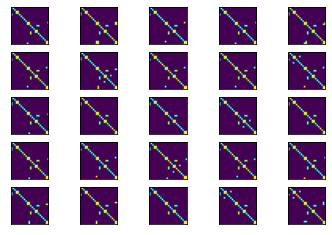

In [3]:
plt.figure(1)
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_3D[i, :, :])
plt.show()

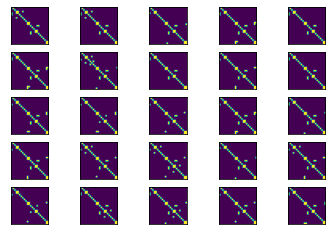

In [4]:
plt.figure(2)
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(val_3D[i, :, :])
plt.show()

In [5]:
print(str(time.ctime()) + ": Implementing PCA Clustering...")
train_pca = np.resize(train_3D, (train_3D.shape[0], int((train_3D.shape[1] * train_3D.shape[2]) / 2)))  # 616207 x 288
val_pca = np.resize(val_3D, (val_3D.shape[0], int((val_3D.shape[1] * val_3D.shape[2]) / 2)))  # 152052 x 288

normalized_train_pca = normalize(train_pca, axis=0)
normalized_val_pca = normalize(val_pca, axis=0)

pca = PCA(2)  # 2 PCs
pca.fit(normalized_train_pca)
reduced_train = pca.transform(normalized_train_pca)
reduced_val = pca.transform(normalized_val_pca) # reduce dimensions of both sets

print('Total explained variance: {}'.format(pca.explained_variance_ratio_.sum() * 100))

print(str(time.ctime()) + ": Finished PCA Clustering!")

Tue Jun 15 14:41:30 2021: Implementing PCA Clustering...
Total explained variance: 59.59740171040322
Tue Jun 15 14:41:40 2021: Finished PCA Clustering!


In [6]:
print(str(time.ctime()) + ": Implementing PCA ML...")

batch_size = 128
epochs = 10

pcamodel = Sequential()
pcamodel.add(Dense(1024, activation='relu', input_shape=(None, 2)))
pcamodel.add(Dense(512, activation='relu'))
pcamodel.add(Dense(256, activation='relu'))
pcamodel.add(Dense(128, activation='relu'))
pcamodel.add(Dense(3, activation='softmax'))

pcamodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = pcamodel.fit(reduced_train, lt_onehot, batch_size=batch_size, epochs=epochs)

print(str(time.ctime()) + ": Finished PCA ML")

Tue Jun 15 14:41:40 2021: Implementing PCA ML...
Epoch 1/10
4815/4815 [==============================] - 8s 2ms/step - loss: 1.0986 - accuracy: 0.3379
Epoch 2/10
4815/4815 [==============================] - 7s 2ms/step - loss: 1.0986 - accuracy: 0.3377
Epoch 3/10
4815/4815 [==============================] - 7s 2ms/step - loss: 1.0986 - accuracy: 0.3349
Epoch 4/10
4815/4815 [==============================] - 7s 1ms/step - loss: 1.0986 - accuracy: 0.3360
Epoch 5/10
4815/4815 [==============================] - 7s 2ms/step - loss: 1.0986 - accuracy: 0.3348
Epoch 6/10
4815/4815 [==============================] - 7s 2ms/step - loss: 1.0986 - accuracy: 0.3353
Epoch 7/10
4815/4815 [==============================] - 7s 1ms/step - loss: 1.0986 - accuracy: 0.3364
Epoch 8/10
4815/4815 [==============================] - 7s 2ms/step - loss: 1.0986 - accuracy: 0.3364
Epoch 9/10
4815/4815 [==============================] - 7s 1ms/step - loss: 1.0986 - accuracy: 0.3370
Epoch 10/10
4815/4815 [==========

In [7]:
print(str(time.ctime()) + ": Predicting with PCA Model...")

result = pcamodel.predict(reduced_val)
result = np.argmax(np.round(result), axis=1)

print(str(time.ctime()) + ": Finished predictions!")

Tue Jun 15 14:42:53 2021: Predicting with PCA Model...
Tue Jun 15 14:42:55 2021: Finished predictions!


In [8]:
correct = np.where(result == label_validation)[0]
incorrect = np.where(result != label_validation)[0]
print("Number of Correct Classifications: " + str(len(correct)))
print("Number of Incorrect Classifications: " + str(len(incorrect)))

Number of Correct Classifications: 50802
Number of Incorrect Classifications: 103250


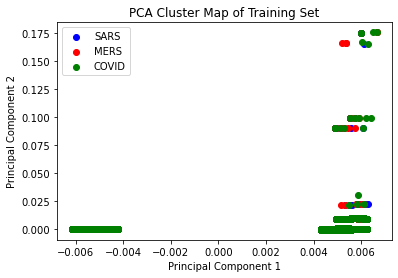

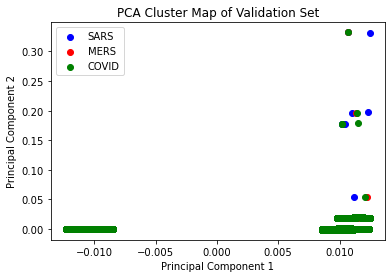

In [9]:
plt.figure(1)
plt.scatter(reduced_train[label_training == 0, 0], reduced_train[label_training == 0, 1], c='b', label='SARS', alpha=1)
plt.scatter(reduced_train[label_training == 1, 0], reduced_train[label_training == 1, 1], c='r', label='MERS', alpha=1)
plt.scatter(reduced_train[label_training == 2, 0], reduced_train[label_training == 2, 1], c='g', label='COVID', alpha=1)
plt.legend(loc='upper left')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Cluster Map of Training Set')

plt.figure(2)
plt.scatter(reduced_val[label_validation == 0, 0], reduced_val[label_validation == 0, 1], c='b', label='SARS', alpha=1)
plt.scatter(reduced_val[label_validation == 1, 0], reduced_val[label_validation == 1, 1], c='r', label='MERS', alpha=1)
plt.scatter(reduced_val[label_validation == 2, 0], reduced_val[label_validation == 2, 1], c='g', label='COVID', alpha=1)
plt.legend(loc='upper left')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Cluster Map of Validation Set')

plt.show()

In [10]:
print(str(time.ctime()) + ": Implementing K-Means Clustering...")
km = KMeans(n_clusters=3, random_state=0)
km.fit(train_pca)
labels_train = np.array(km.predict(train_pca))
labels_val = np.array(km.predict(val_pca))

accuracy = (sum(labels_val == label_validation) / len(label_validation)) * 100

print('Accuracy: {}'.format(accuracy))
print(str(time.ctime()) + ": Finished K-Means Clustering!")

Tue Jun 15 14:42:56 2021: Implementing K-Means Clustering...
Accuracy: 33.12517851115208
Tue Jun 15 14:43:12 2021: Finished K-Means Clustering!


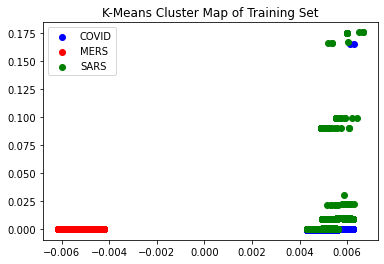

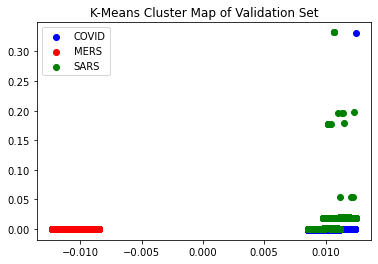

In [11]:
plt.figure(3)
plt.scatter(reduced_train[labels_train == 0, 0], reduced_train[labels_train == 0, 1], c='b', label='COVID')
plt.scatter(reduced_train[labels_train == 1, 0], reduced_train[labels_train == 1, 1], c='r', label='MERS')
plt.scatter(reduced_train[labels_train == 2, 0], reduced_train[labels_train == 2, 1], c='g', label='SARS')
plt.title('K-Means Cluster Map of Training Set')
plt.legend(loc='upper left')

plt.figure(4)
plt.scatter(reduced_val[labels_val == 0, 0], reduced_val[labels_val == 0, 1], c='b', label='COVID')
plt.scatter(reduced_val[labels_val == 1, 0], reduced_val[labels_val == 1, 1], c='r', label='MERS')
plt.scatter(reduced_val[labels_val == 2, 0], reduced_val[labels_val == 2, 1], c='g', label='SARS')
plt.title('K-Means Cluster Map of Validation Set')
plt.legend(loc='upper left')

plt.show()

In [12]:
train_X, valid_X, train_label, valid_label = train_test_split(trainset, lt_onehot, test_size=0.2, random_state=13)
# train_X = 492965 x 24 x 24 x 1
# valid_X = 123242 x 24 x 24 x 1
# train_label = 492965 x 3
# valid_label = 123242 x 3

In [13]:
print(str(time.ctime()) + ": Creating Classification Model...")

x = Input(shape=(24, 24, 1))  # 24 x 24 x 1

e_conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x) # 24 x 24 x 32
pool1 = MaxPool2D((2, 2), padding='same')(e_conv1) # 12 x 12 x 32
b_norm1 = BatchNormalization()(pool1)

e_conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(b_norm1) # 12 x 12 x 64
pool2 = MaxPool2D((2, 2), padding='same')(e_conv2) # 6 x 6 x 64
b_norm2 = BatchNormalization()(pool2)

e_conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(b_norm2) # 6 x 6 x 128
pool3 = MaxPool2D((2, 2), padding='same')(e_conv3) # 3 x 3 x 128
b_norm3 = BatchNormalization()(pool3)

d_conv1 = Conv2D(128, (3, 3), activation='relu', padding='same')(b_norm3) # 3 x 3 x 128
up1 = UpSampling2D((2, 2))(d_conv1) # 6 x 6 x 128
b_norm4 = BatchNormalization()(up1)

d_conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(b_norm4) # 6 x 6 x 64
up2 = UpSampling2D((2, 2))(d_conv2) # 12 x 12 x 64
b_norm5 = BatchNormalization()(up2)

d_conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(b_norm5) # 12 x 12 x 32
up3 = UpSampling2D((2, 2))(d_conv3) # 24 x 24 x 64
b_norm6 = BatchNormalization()(up3)

d_conv4 = Conv2D(1, (1, 1), activation='relu', padding='same')(b_norm6) # 24 x 24 x 1
b_norm7 = BatchNormalization()(d_conv4)

f1 = Flatten()(b_norm7) # add a fully connected layer after just the autoencoder. 576 x 1
dense_1 = Dense(32, activation='relu')(f1) # 32 x 1
dense_2 = Dense(16, activation='relu')(dense_1) # 16 x 1
dense_3 = Dense(8, activation='relu')(dense_2) # 8 x 1
r = Dense(3, activation='softmax')(dense_3) # 3 x 1

classification_model = Model(x, r) # compile full model
classification_model.compile(loss=keras.losses.categorical_crossentropy, optimizer='sgd', metrics=['accuracy'])

print(str(time.ctime()) + ": Successfully created Classification Model")

Tue Jun 15 14:43:15 2021: Creating Classification Model...
Tue Jun 15 14:43:15 2021: Successfully created Classification Model


In [14]:
print(str(time.ctime()) + ": Training Classification Model...")

epochs = 10
batch_size = 256
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
classify_labels = classification_model.fit(train_X, train_label, batch_size=batch_size, epochs=epochs, callbacks=[early_stop])

print(str(time.ctime()) + ": Finished training!")

Tue Jun 15 14:43:15 2021: Training Classification Model...
Epoch 1/10
1926/1926 [==============================] - 15s 7ms/step - loss: 0.5171 - accuracy: 0.7168
Epoch 2/10
1926/1926 [==============================] - 13s 7ms/step - loss: 0.4257 - accuracy: 0.7403
Epoch 3/10
1926/1926 [==============================] - 13s 7ms/step - loss: 0.4258 - accuracy: 0.7417
Epoch 4/10
1926/1926 [==============================] - 13s 7ms/step - loss: 0.4252 - accuracy: 0.7411
Epoch 5/10
1926/1926 [==============================] - 13s 7ms/step - loss: 0.4245 - accuracy: 0.7427
Epoch 6/10
1926/1926 [==============================] - 13s 7ms/step - loss: 0.4245 - accuracy: 0.7431
Epoch 7/10
1926/1926 [==============================] - 13s 7ms/step - loss: 0.4248 - accuracy: 0.7414
Epoch 8/10
1926/1926 [==============================] - 13s 7ms/step - loss: 0.4246 - accuracy: 0.7425
Epoch 9/10
1926/1926 [==============================] - 13s 7ms/step - loss: 0.4244 - accuracy: 0.7425
Epoch 10/10
19

In [15]:
print(str(time.ctime()) + ": Evaluating Classification Model...")

test_eval = classification_model.evaluate(valid_X, valid_label)
print('Loss: {}'.format(test_eval[0]))
print('Accuracy: {}'.format(test_eval[1] * 100))

print(str(time.ctime()) + ": Finished evaluation!")

Tue Jun 15 14:45:29 2021: Evaluating Classification Model...
3852/3852 [==============================] - 8s 2ms/step - loss: 0.4259 - accuracy: 0.7407
Loss: 0.4259135127067566
Accuracy: 74.06728267669678
Tue Jun 15 14:45:38 2021: Finished evaluation!


In [16]:
print(str(time.ctime()) + ": Predicting with Classification Model...")

predicted = classification_model.predict(valset)
predicted = np.argmax(np.round(predicted), axis=1)

print(str(time.ctime()) + ": Finished predictions!")

Tue Jun 15 14:45:38 2021: Predicting with Classification Model...
Tue Jun 15 14:45:44 2021: Finished predictions!


In [17]:
correct = np.where(predicted == label_validation)[0]
incorrect = np.where(predicted != label_validation)[0]
print("Number of Correct Classifications: " + str(len(correct)))
print("Number of Incorrect Classifications: " + str(len(incorrect)))

Number of Correct Classifications: 114160
Number of Incorrect Classifications: 39892


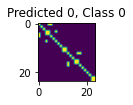

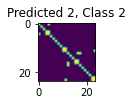

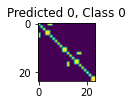

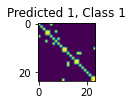

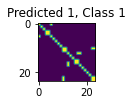

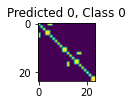

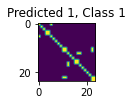

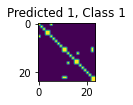

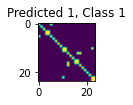

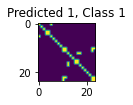

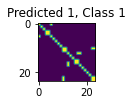

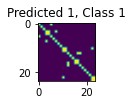

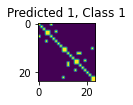

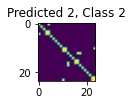

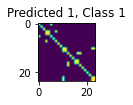

In [18]:
plt.figure(7)
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(valset[correct[i], :, :])
    plt.title("Predicted {}, Class {}".format(predicted[correct[i]], int(label_validation[correct[i]])))
    plt.show()